In [4]:
import pandas as pd
import numpy as np
import torch
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import scienceplots
import matplotlib.pyplot as plt

from data_process import process_data, get_score, EMA

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


(2849, 60, 2) (2849, 2)
load model: data/model/modelLSTM_file2013_2022DRPDRY_seq60_NormalizeTrue.pt
(13.357343, 2.2165017, 0.648071159975055, 0.4035780367067188, 3.65477)
(2819, 90, 2) (2819, 2)
load model: data/model/modelCNN_LSTM_bi_file2013_2022DRPDRY_seq90_NormalizeTrue.pt
(13.900131, 2.2410476, 0.6359857246500161, 0.3963988766089187, 3.728288)
(2849, 60, 2) (2849, 2)
load model: data/model/modelGRU_file2013_2022DRPDRY_seq60_NormalizeTrue.pt
(15.073693, 2.3292267, 0.6028501302558402, 0.38433337602459017, 3.8824854)
(2544, 365, 2) (2544, 2)
load model: data/model/modelLSTM_file2013_2022DRPDRY_seq365_NormalizeTrue.pt
(14.85647, 2.4289498, 0.5845575255901381, 0.39433122955406336, 3.8544092)


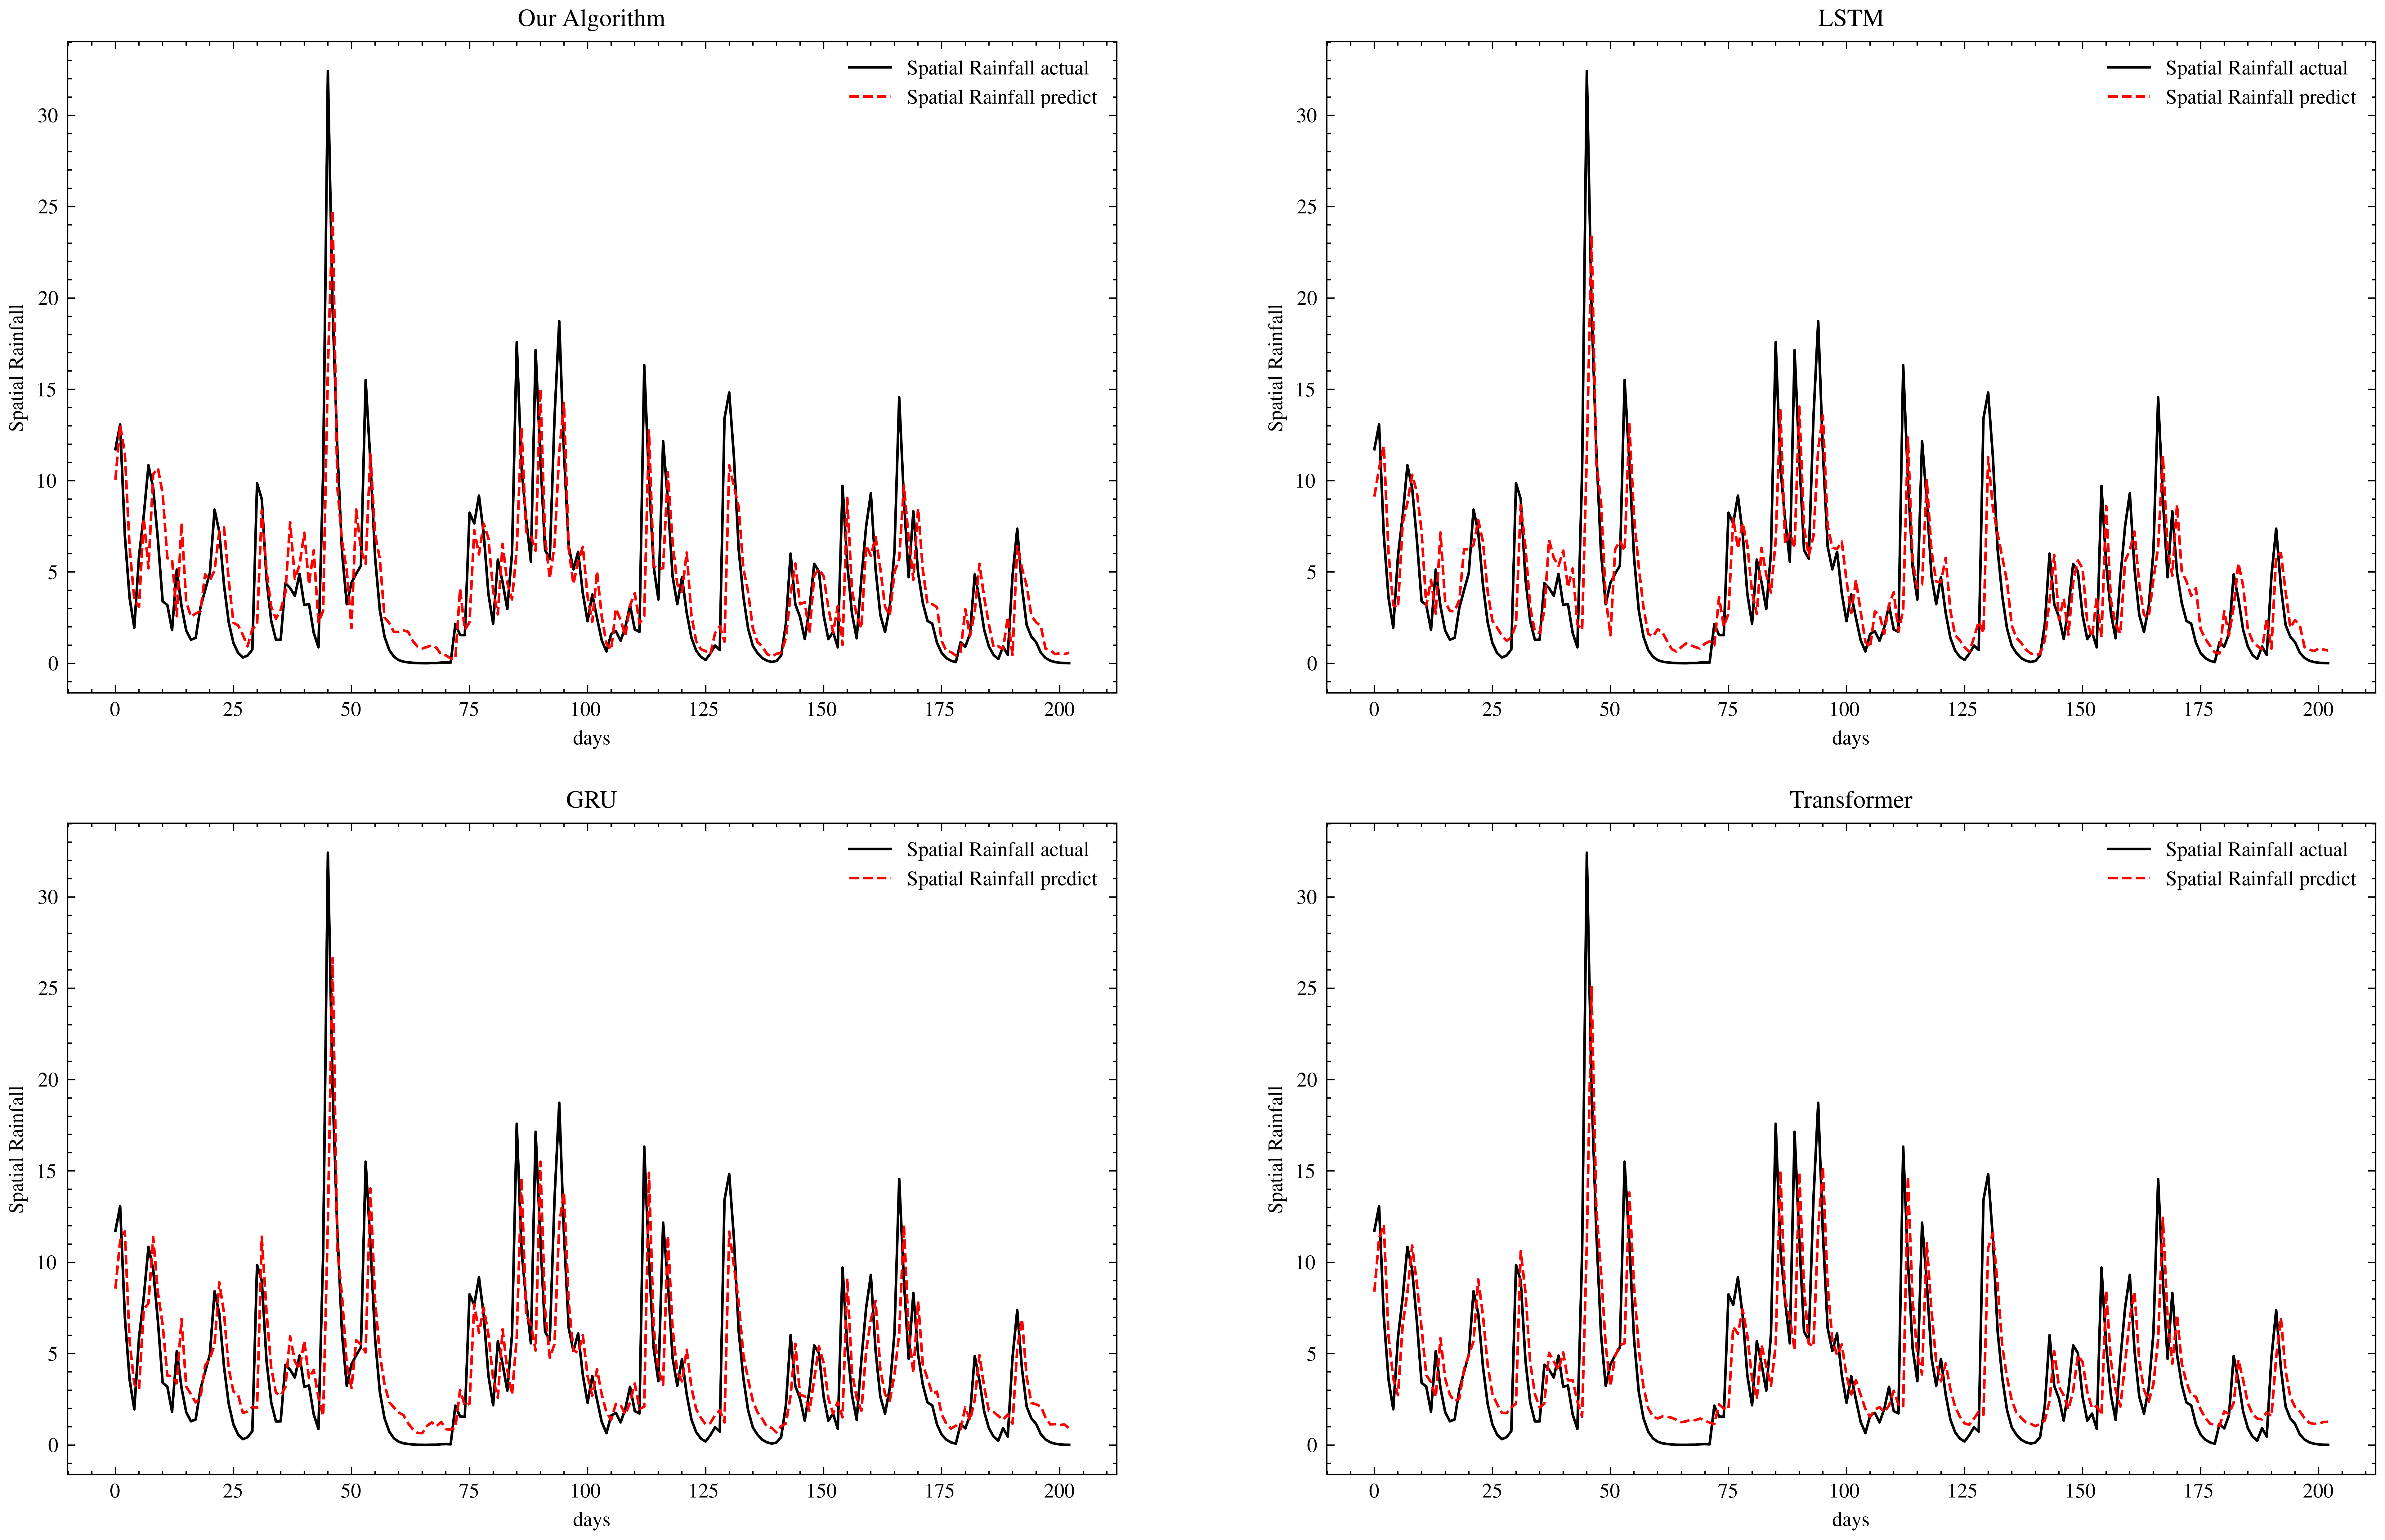

In [5]:
# 读取模型

files = ['2015_2020', '2013_2022DRPDRY', '330112MYL']
models = ['LSTM', 'GRU', 'CNN_LSTM', 'CNN_LSTM_PRO', 'CNN_GRU', 'LSTM_Attention', 'LSTMAttention']


def load_model(file=0, model=0, seq=50, Normalize=True, bidirection=False):
    load_model = models[model]
    load_file = files[file]
    load_seq = seq
    load_Normalize = Normalize
    load_bidirection = bidirection
    dataX, dataY, trainX, trainY, testX, testY, scaler = process_data(load_file, load_seq, load_Normalize)
    load_Path = f'data/model/model{load_model}{"_bi" if load_bidirection else ""}_file{load_file}_seq{load_seq}_Normalize{load_Normalize}.pt'

    print(f'load model: {load_Path}')
    model = torch.load(load_Path, map_location=torch.device('cpu'))
    model.eval()
    train_predict = model(dataX)
    data_predict = train_predict.cpu().data.numpy()
    dataY_plot = dataY.cpu().data.numpy()
    data_predict = scaler.inverse_transform(data_predict)
    # data_predict[:,query_index] = np.array(normalization(data_predict[:,query_index]))
    dataY_plot = scaler.inverse_transform(dataY_plot)
    # data_predict[:,query_index] = np.array(rainfall_to_level(data_predict[:,query_index]))
    # dataY_plot[:,query_index] = np.array(rainfall_to_level(dataY_plot[:,query_index]))
    return dataY_plot, data_predict, seq


def rainfall_to_level(pp):
    res = []
    for i in pp:
        res.append(0 if i <= 2 else (
            1 if i <= 10 else (2 if i <= 25 else (3 if i <= 50 else (4 if i <= 100 else (5 if i <= 250 else 6))))))
    return res


def normalization(data_predict):
    res = []
    for i in data_predict:
        x = []
        # x.append(1 if i <= 1.5 else (2 if i <= 2.125 else (
        #     3 if i <= 3 else (4 if i <= 4 else (5 if i <= 5 else (6 if i <= 6 else 7))))))
        # x.append(i + 20)
        res.append(((i / 3.5) ** 3))
    return res
    # v_ema = []
    # v_ema_corr = []
    # v_pre = 0
    # for i, t in enumerate(data):
    #     v_t = beta * v_pre + (1 - beta) * t
    #     v_ema.append(v_t)
    #     v_pre = v_t
    #
    # for i, t in enumerate(v_ema):
    #     v_ema_corr.append(t / (1 - np.power(beta, i + 1)))
    # return v_ema_corr


la = [["Inflow", "Outflow", "Spatial Rainfall", "Spatial Evaporation", "outflow and inflow"],
      ["Spatial Rainfall", "Spatial Evaporation"]]
file = 1
query_index = 0
ss1, ss2 = 20, 27
with plt.style.context(['science', 'ieee']):
    plt.figure(figsize=(16, 10))

    Y1, P1, seq1 = load_model(file, 0, 60, True, False)
    print(get_score(P1[:, query_index], Y1[:, query_index]))
    plt.subplot(2, 2, 1)
    s1 = (Y1.shape[0] + seq1) // 100 * ss1
    s2 = (Y1.shape[0] + seq1) // 100 * ss2
    plt.plot(Y1[365 - seq1 + s1:365 - seq1 + s2, query_index], label=f'{la[file][query_index]} actual')
    # plt.plot(dataY_plot[trainX.shape[0] - dataX.shape[0]:, query_index], label='DYE actual')
    plt.plot(P1[365 - seq1 + s1:365 - seq1 + s2, query_index], label=f'{la[file][query_index]} predict')
    plt.xlabel('days')
    plt.ylabel(f'{la[file][query_index]}')
    plt.title('Our Algorithm')
    plt.legend()

    Y1, P1, seq1 = load_model(file, 2, 90, True, True)
    print(get_score(P1[:, query_index], Y1[:, query_index]))
    plt.subplot(2, 2, 2)
    s1 = (Y1.shape[0] + seq1) // 100 * ss1
    s2 = (Y1.shape[0] + seq1) // 100 * ss2
    plt.plot(Y1[365 - seq1 + s1:365 - seq1 + s2, query_index], label=f'{la[file][query_index]} actual')
    # plt.plot(dataY_plot[trainX.shape[0] - dataX.shape[0]:, query_index], label='DYE actual')
    plt.plot(P1[365 - seq1 + s1:365 - seq1 + s2, query_index], label=f'{la[file][query_index]} predict')
    plt.xlabel('days')
    plt.ylabel(f'{la[file][query_index]}')
    plt.title('LSTM')
    plt.legend()

    Y1, P1, seq1 = load_model(file, 1, 60, True, False)
    print(get_score(P1[:, query_index], Y1[:, query_index]))
    plt.subplot(2, 2, 3)
    s1 = (Y1.shape[0] + seq1) // 100 * ss1
    s2 = (Y1.shape[0] + seq1) // 100 * ss2
    plt.plot(Y1[365 - seq1 + s1:365 - seq1 + s2, query_index], label=f'{la[file][query_index]} actual')
    # plt.plot(dataY_plot[trainX.shape[0] - dataX.shape[0]:, query_index], label='DYE actual')
    plt.plot(P1[365 - seq1 + s1:365 - seq1 + s2, query_index], label=f'{la[file][query_index]} predict')
    plt.xlabel('days')
    plt.ylabel(f'{la[file][query_index]}')
    plt.title('GRU')
    plt.legend()

    Y1, P1, seq1 = load_model(file, 0, 365, True, False)
    print(get_score(P1[:, query_index], Y1[:, query_index]))
    plt.subplot(2, 2, 4)
    s1 = (Y1.shape[0] + seq1) // 100 * ss1
    s2 = (Y1.shape[0] + seq1) // 100 * ss2
    plt.plot(Y1[365 - seq1 + s1:365 - seq1 + s2, query_index], label=f'{la[file][query_index]} actual')
    # plt.plot(dataY_plot[trainX.shape[0] - dataX.shape[0]:, query_index], label='DYE actual')
    plt.plot(P1[365 - seq1 + s1:365 - seq1 + s2, query_index], label=f'{la[file][query_index]} predict')
    plt.xlabel('days')
    plt.ylabel(f'{la[file][query_index]}')
    plt.title('Transformer')
    plt.legend()
    # print(data_predict.shape[0] + load_seq)
    # plt.plot(data_predict[trainX.shape[0] - dataX.shape[0]:, query_index], label='DYE predict')
    # plt.axvline(x=trainX.shape[0], c='r', linestyle='--')
    # plt.xticks(fontsize=16)
    # plt.yticks(fontsize=16)
    # plt.savefig(f'data/img/{files[file]}_{la[file][query_index]}_predict.svg')
    plt.show()

In [ ]:
# data_predict1 = data_predict[trainX.shape[0]:, query_index] - dataY_plot[trainX.shape[0]:, query_index]
# sum = 0
# for i in data_predict1:
#     if
# i == 0:
# sum += 1
# print(sum)
# print(sum / len(data_predict1))

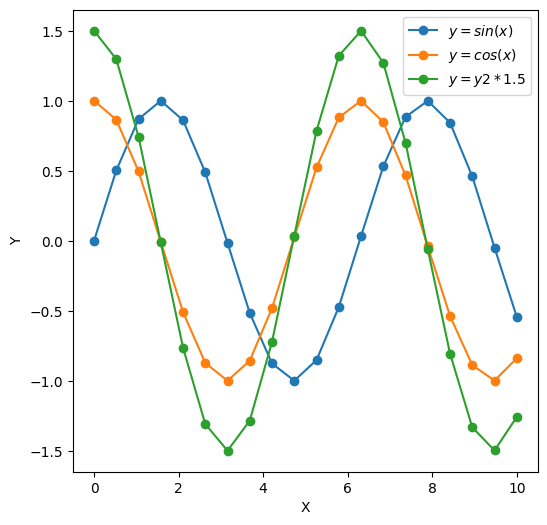

In [6]:

# 生成x值
x = np.linspace(0, 10, 20)

# 生成带有随机噪声的y值
y = np.sin(x)
y2 = np.cos(x)
y3 = y2 * 1.5
plt.figure(figsize=(6, 6))
plt.plot(x, y, marker='o', label='$y=sin(x)$')
plt.plot(x, y2, marker='o', label='$y=cos(x)$')
plt.plot(x, y3, marker='o', label='$y=y2*1.5$')

plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()

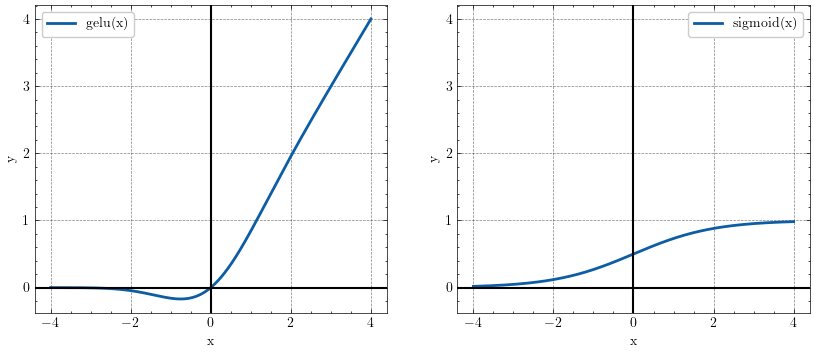

In [7]:
from scipy.stats import norm
import numpy as np


def elu(x, alpha=1.0):
    return np.where(x > 0, x, alpha * (np.exp(x) - 1))


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def gelu(x):
    return x * norm.cdf(x)


# Test the functions with a sample input
x = np.linspace(-4, 4, 500)
gelu_result = gelu(x)
elu_result = elu(x)
sigmoid_result = sigmoid(x)

elu_result, sigmoid_result

with plt.style.context(['science', 'grid']):
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))  # 使用子图返回的axs进行绘图

    # 绘制第一个子图
    axs[0].plot(x, gelu_result, label='gelu(x)', linewidth=2)
    axs[0].set_xlabel('x')
    axs[0].set_ylabel('y')
    axs[0].legend()
    # axs[0].legend(frameon=False, fontsize=10)

    # 绘制第二个子图
    axs[1].plot(x, sigmoid_result, label='sigmoid(x)', linewidth=2)
    axs[1].set_xlabel('x')
    axs[1].set_ylabel('y')
    axs[1].legend()
    # axs[1].legend(frameon=False, fontsize=10)

    # 获取两个子图的x轴和y轴界限
    xlims = [ax.get_xlim() for ax in axs]
    ylims = [ax.get_ylim() for ax in axs]

    # 找出所有子图中的最大界限
    xlim = (min(xlims[0][0], xlims[1][0]), max(xlims[0][1], xlims[1][1]))
    ylim = (min(ylims[0][0], ylims[1][0]), max(ylims[0][1], ylims[1][1]))

    # 将最大界限应用到所有子图
    for ax in axs:
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        ax.axhline(y=0, color='black', linewidth=1.5)  # 添加水平y=0线
        ax.axvline(x=0, color='black', linewidth=1.5)  # 添加垂直x=0线
    plt.savefig('data/img/gelu_sigmoid.svg')
    plt.show()


In [8]:
# EMA
files = ['2015_2020', '2013_2022DRPDRY', '330112MYL']
file = files[1]
models = ['LSTM', 'GRU', 'CNN_LSTM', 'CNN_LSTM_PRO', 'CNN_GRU', 'LSTM_Attention', 'LSTMAttention']
load_model = models[0]
load_file = file
load_seq = 60
load_Normalize = False
load_bidirection = True
dataX, dataY, trainX, trainY, testX, testY, scaler = process_data(file, load_seq, False)
dataX1, dataY1, trainX1, trainY1, testX1, testY1, scaler1 = process_data(file, load_seq, True)
# load_Path = f'data/model/model{load_model}{"_bi" if load_bidirection else ""}_file{load_file}_seq{load_seq}_Normalize{load_Normalize}.pt'
plt.show()
plt.clf()
la = ["Spatial Rainfall", "Spatial Evaporation", "", "", "Outflow and Inflow"]
query_index = 1
# la = "spatial evaporation"
# data_predict = scaler.inverse_transform(data_predict)
# data_predict[:,query_index] = np.array(normalization(data_predict[:,query_index]))
# dataY_plot = scaler.inverse_transform(dataY_plot)
# data_predict[:,query_index] = np.array(rainfall_to_level(data_predict[:,query_index]))
# dataY_plot[:,query_index] = np.array(rainfall_to_level(dataY_plot[:,query_index]))
s1 = 365 - load_seq + (dataY.shape[0] + load_seq) // 100 * 45
s2 = 365 - load_seq + (dataY.shape[0] + load_seq) // 100 * 50
with plt.style.context(['science', 'grid']):
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))  # 使用子图返回的axs进行绘图

    # 绘制第一个子图
    axs[0].plot(dataY[s1:s2, query_index], label='before_EMA')
    axs[0].set_xlabel('Days')
    axs[0].set_ylabel(f'{la[query_index]}')
    axs[0].legend()

    # 绘制第二个子图
    axs[1].plot(dataY1[s1:s2, query_index], label='after_EMA')
    axs[1].set_xlabel('Days')
    axs[1].set_ylabel(f'{la[query_index]}')
    axs[1].legend()

    # 获取两个子图的x轴和y轴界限
    xlims = [ax.get_xlim() for ax in axs]
    ylims = [ax.get_ylim() for ax in axs]

    # 找出所有子图中的最大界限
    xlim = (min(xlims[0][0], xlims[1][0]), max(xlims[0][1], xlims[1][1]))
    ylim = (min(ylims[0][0], ylims[1][0]), max(ylims[0][1], ylims[1][1]))

    # 将最大界限应用到所有子图
    for ax in axs:
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)

    plt.savefig('data/img/EMA.svg')
    # print(get_score(data_predict[trainX.shape[0]:, query_index], dataY_plot[trainX.shape[0]:, query_index]))

(2849, 60, 2) (2849, 2)
(2849, 60, 2) (2849, 2)
